## CS6140 Final project 
### Can Tree-Based Models Always Outperform Neural Networks on Tabular Data?
#### Author: Yuxuan Wang and Pranav Sirnapalli

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.datasets import fetch_california_housing
from sklearn.compose import ColumnTransformer

from random_forest_classifier import RandomForestBinaryClassifier
from random_forest_regessor import RandomForestRegressor
from mlp_model import MLPTrainer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Loading and Preprocessing 

In [36]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

adult_data = pd.read_csv(url, names=columns, skipinitialspace=True)
adult_data = adult_data.replace('?', np.nan).dropna()

adult_X = adult_data.drop('income', axis=1)
adult_y = (adult_data['income'] == '>50K').astype(int)

print(f" Adult data: {adult_X.shape}, positive label rate: {adult_y.mean():.3f}")

 Adult data: (30162, 14), positive label rate: 0.249


#### Adult_Income_data

In [37]:
categorical_cols = adult_X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = adult_X.select_dtypes(include=[np.number]).columns.tolist()

# Random Forest data（encode label)
adult_X_rf = adult_X.copy()
for col in categorical_cols:
    le = LabelEncoder()
    adult_X_rf[col] = le.fit_transform(adult_X_rf[col])

# MLP data processing（std + One-Hot）
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)
adult_X_mlp = preprocessor.fit_transform(adult_X)

print(f" RF feature shape: {adult_X_rf.shape},  MLP feature shape: {adult_X_mlp.shape}")


adult_X_rf_train, adult_X_rf_test, adult_y_train, adult_y_test = train_test_split(
    adult_X_rf, adult_y, test_size=0.2, random_state=RANDOM_STATE, stratify=adult_y
)
adult_X_mlp_train, adult_X_mlp_test, _, _ = train_test_split(
    adult_X_mlp, adult_y, test_size=0.2, random_state=RANDOM_STATE, stratify=adult_y
)

 RF feature shape: (30162, 14),  MLP feature shape: (30162, 96)


#### California_housing_data

In [38]:
california = fetch_california_housing()
california_X = pd.DataFrame(california.data, columns=california.feature_names)
california_y = california.target

print(f"California data shape: {california_X.shape}, Target mean: ${california_y.mean():.2f}k")


california_X_rf = california_X.copy()

scaler = StandardScaler()
california_X_mlp = scaler.fit_transform(california_X)

california_X_rf_train, california_X_rf_test, california_y_train, california_y_test = train_test_split(
    california_X_rf, california_y, test_size=0.2, random_state=RANDOM_STATE
)
california_X_mlp_train, california_X_mlp_test, _, _ = train_test_split(
    california_X_mlp, california_y, test_size=0.2, random_state=RANDOM_STATE
)

California data shape: (20640, 8), Target mean: $2.07k


## Part 1: Classification – UCI Adult
- Tree: RandomForest / XGBoost
- MLP: PyTorch MLPClassifier
- Metric: Accuracy / AUC

### Random Forest Classifier Trainning

In [42]:

rf_classifier = RandomForestBinaryClassifier(random_state=RANDOM_STATE)

print(" Finding the best paramas...")
best_params = rf_classifier.tune_hyperparameters(adult_X_rf_train, adult_y_train, cv_folds=3)
print(f"Best Params: {best_params}")

rf_classifier.train(adult_X_rf_train, adult_y_train, use_tuned_params=True)

rf_metrics = rf_classifier.evaluate(adult_X_rf_test, adult_y_test)
print("\n Random Forest Result:")
for metric, value in rf_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

cv_results = rf_classifier.cross_validate(adult_X_rf_train, adult_y_train)
print("\n Cross Valid Result:")
print(f"  AUC: {cv_results['auc_mean']:.4f} ± {cv_results['auc_std']:.4f}")

 Finding the best paramas...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

 Random Forest Result:
  ACCURACY: 0.8606
  F1_SCORE: 0.6879
  AUC: 0.9147

 Cross Valid Result:
  AUC: 0.9158 ± 0.0051


### MLP Classifier Trainning

Epoch [10/100], Train Loss: 0.3084, Val Loss: 0.3198
Early stopping at epoch 16


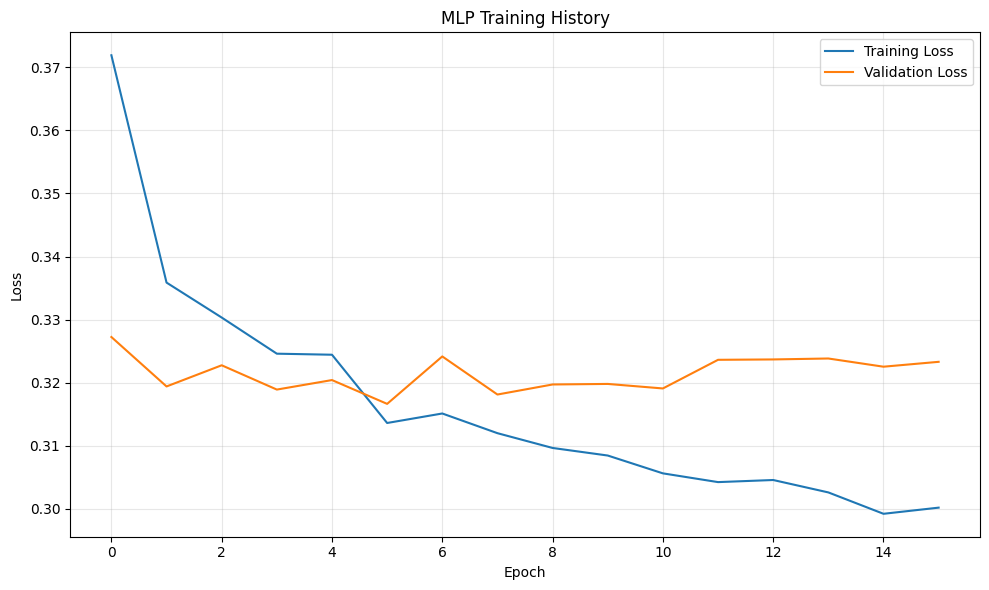


 MLP Classifier Results:
  ACCURACY: 0.8513
  F1_SCORE: 0.6627
  AUC: 0.9077


In [ ]:
mlp_classifier = MLPTrainer(
    model_type='classifier',
    hidden_dims=[256, 128, 64],  # Hidden layer dimensions
    dropout_rate=0.3,            # Dropout rate
    learning_rate=0.001,
    batch_size=64,
    random_state=RANDOM_STATE
)

# Train the model
training_history = mlp_classifier.train(
    adult_X_mlp_train, adult_y_train.values,
    epochs=100,
    validation_split=0.2,          
    early_stopping_patience=10,    # Early stopping patience
    verbose=True                   
)

# Plot training and validation loss
mlp_classifier.plot_training_history()

# Evaluate the model on the test set
mlp_metrics = mlp_classifier.evaluate(adult_X_mlp_test, adult_y_test.values)
print("\n MLP Classifier Results:")
for metric, value in mlp_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")


### XGBoost Classifier Trainning

## Part 2: Regression – California Housing
- Tree: RandomForestRegressor / XGBoostRegressor
- MLP: PyTorch MLPRegressor
- Metric: RMSE / R²

### Random Forest Regressior Trainning

 Finding the best paramas...
Fitting 3 folds for each of 324 candidates, totalling 972 fits



 Random Forest Regessior Result:
  RMSE: 0.4902
  R2: 0.8166
  MSE: 0.2403


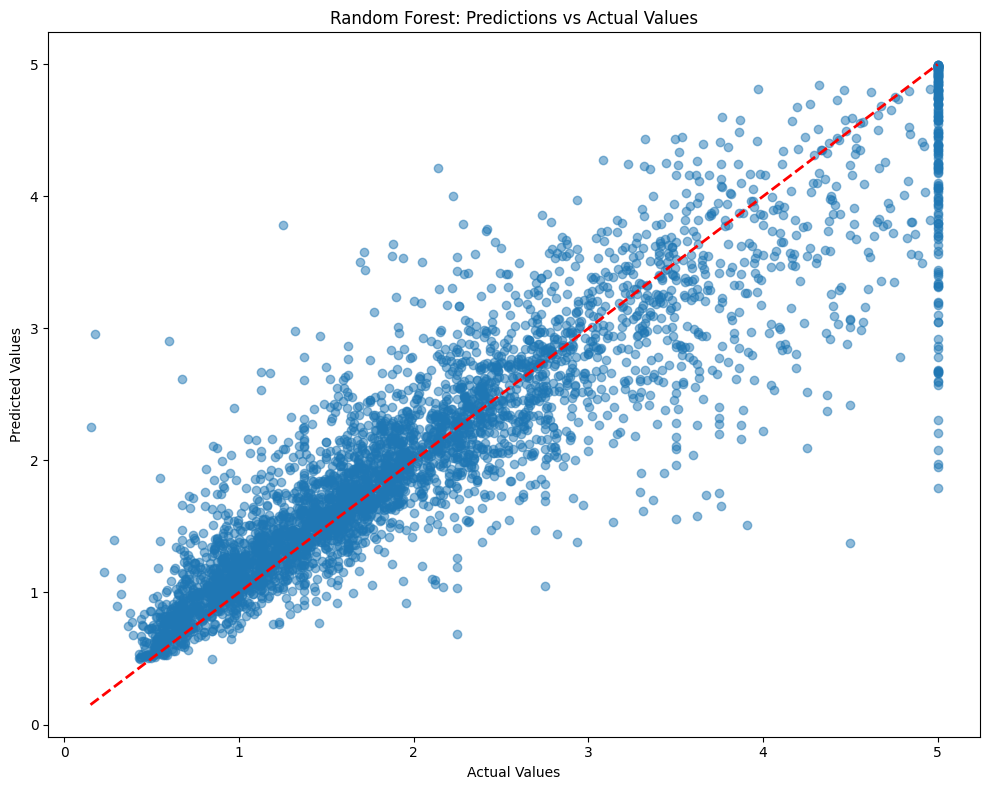

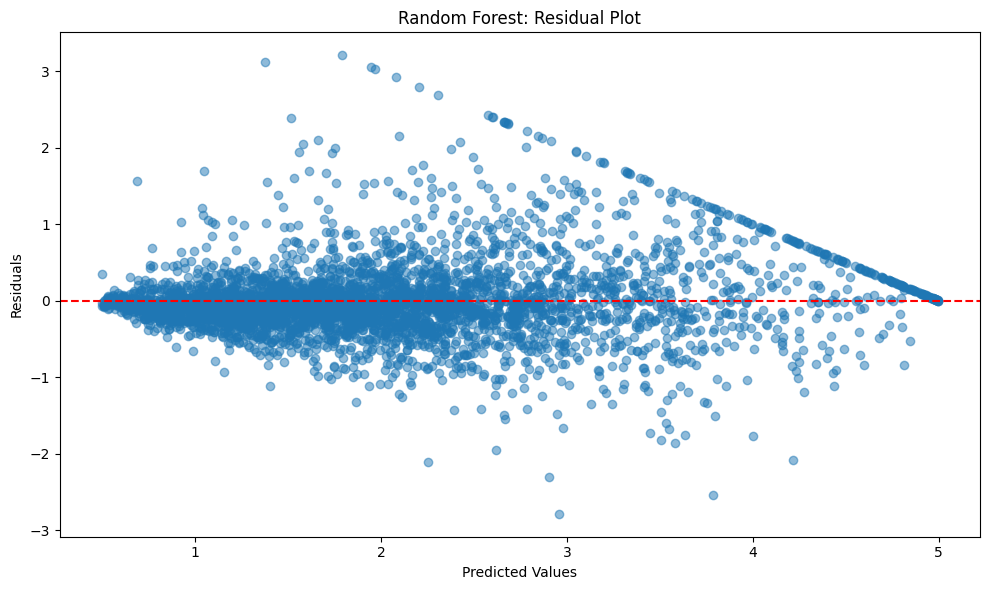

In [ ]:

rf_regressor = RandomForestRegressor(random_state=RANDOM_STATE)

print(" Finding the best paramas...")
best_params = rf_regressor.tune_hyperparameters(california_X_rf_train, california_y_train, cv_folds=3)

rf_regressor.train(california_X_rf_train, california_y_train, use_tuned_params=True)

rf_reg_metrics = rf_regressor.evaluate(california_X_rf_test, california_y_test)
print("\n Random Forest Regessior Result:")
for metric, value in rf_reg_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

rf_regressor.plot_predictions(california_X_rf_test, california_y_test)

### MLP Regressier Trainnning

Epoch [10/100], Train Loss: 0.4100, Val Loss: 0.9304
Early stopping at epoch 12


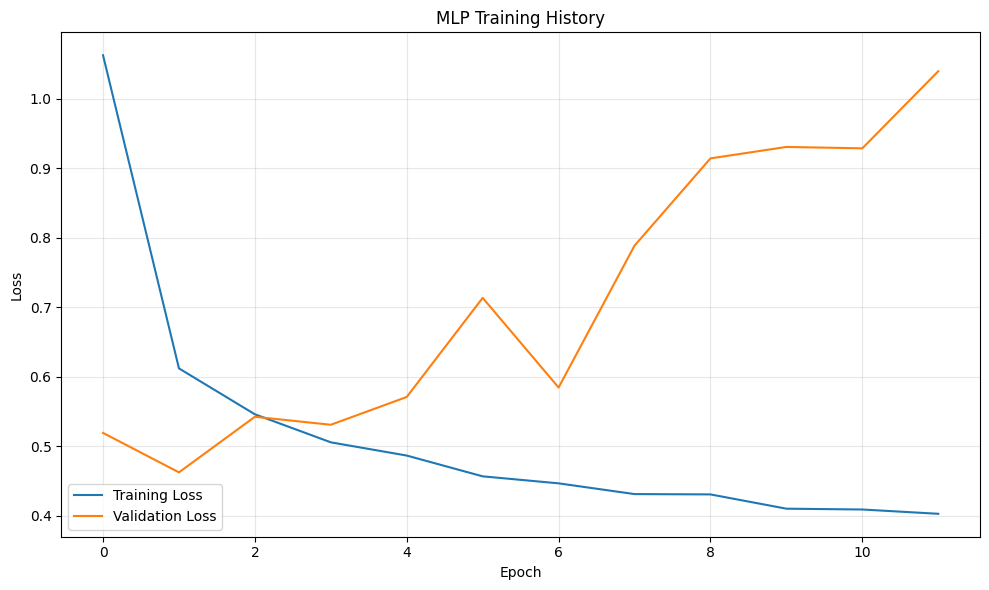


 MLP Regressior Result:
  RMSE: 0.5759
  R2: 0.7469
  MSE: 0.3317


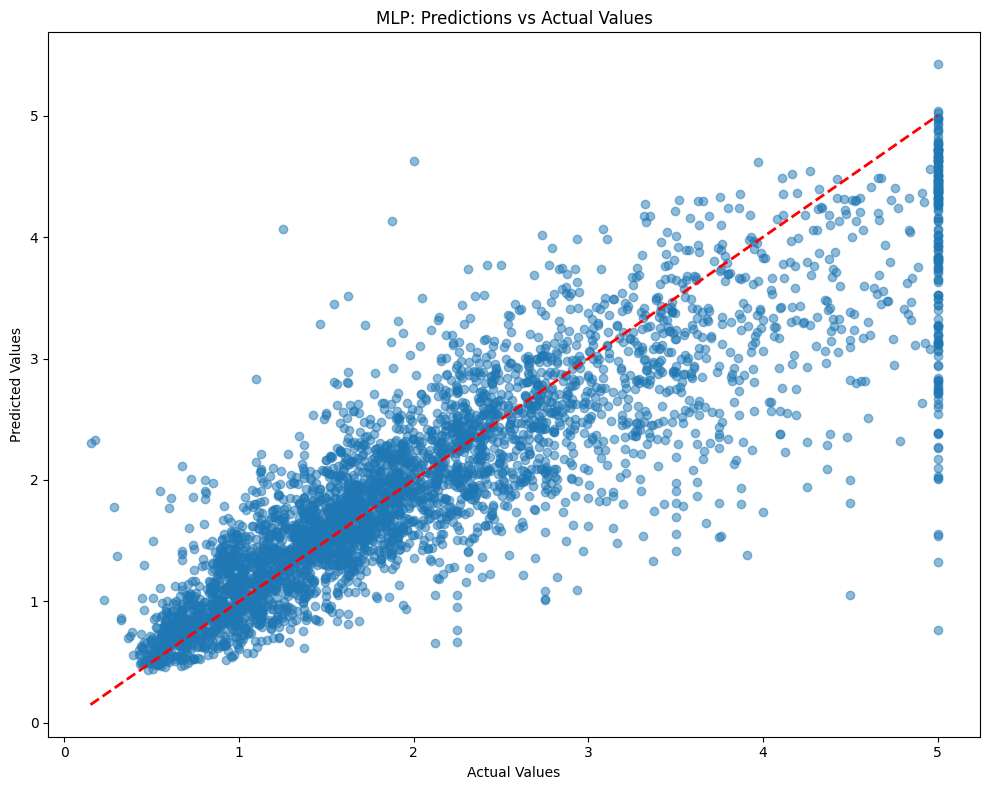

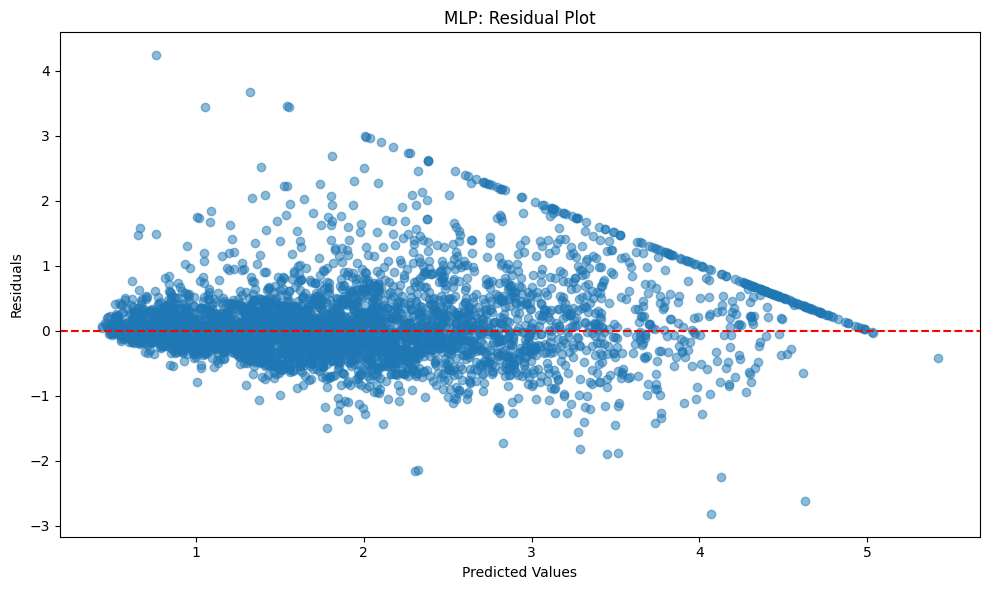

In [41]:
mlp_regressor = MLPTrainer(
    model_type='regressor',
    hidden_dims=[256, 128, 64],
    dropout_rate=0.3,
    learning_rate=0.001,
    batch_size=64,
    random_state=RANDOM_STATE
)


training_history = mlp_regressor.train(
    california_X_mlp_train, california_y_train,
    epochs=100,
    validation_split=0.2,
    early_stopping_patience=10,
    verbose=True
)

mlp_regressor.plot_training_history()

mlp_reg_metrics = mlp_regressor.evaluate(california_X_mlp_test, california_y_test)
print("\n MLP Regressior Result:")
for metric, value in mlp_reg_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

mlp_regressor.plot_predictions(california_X_mlp_test, california_y_test)

### XGBoost Regessior Trainning